In [3]:
import numpy as np
import pandas as pd 
import os
import random

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
#Torch and Tabnet
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Sklearn only for splitting
from sklearn.model_selection import KFold

In [50]:
NUM_FOLDS = 4  # you can specify your folds here
seed = 2020   # seed

In [51]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [52]:
seed_everything(seed)

In [53]:
def metric(y_val, y_pr):
    overall_score=100*max(0,1-np.sqrt(mean_squared_error(y_val,y_pr)))
    return overall_score

In [54]:
df = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
EMP_ID = test['Employee_ID']

df["kfold"] = -1

df = df.sample(frac=1,random_state=2020).reset_index(drop=True)

kf = KFold(n_splits=NUM_FOLDS)

for fold, (trn_, val_) in enumerate(kf.split(X=df, y=df)):
    df.loc[val_, 'kfold'] = fold

In [60]:
df.head(3)

,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,growth_rate,...,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate,kfold,time,age_while_joining
0,0,61.0,1,0,4,3,2,22.0,3,59,...,-0.1048,-1.6150,2.0,4,7,5,0.0590,0.0,19.0,39.0
1,0,64.0,1,1,1,5,3,37.0,1,69,...,0.0000,-0.4537,2.0,2,7,4,0.0313,0.0,36.0,27.0
2,0,26.0,3,0,1,3,1,3.0,2,62,...,0.7516,-0.4537,4.0,3,8,3,0.1479,0.0,1.0,23.0


In [56]:
traintest = df.append(test)
traintest.shape

(10000, 25)

In [57]:
traintest.drop(['Employee_ID'],axis=1,inplace=True)
traintest['VAR4'].fillna(4.0,inplace=True)
traintest['Age'].fillna(traintest.groupby(['Gender', 'Time_since_promotion'])['Age'].transform('median'),inplace=True)
traintest['VAR2'].fillna(0.0,inplace=True)
traintest['Pay_Scale'].fillna(traintest.Pay_Scale.median(),inplace=True)
traintest['Time_of_service'].fillna(traintest.Time_of_service.mean(),inplace=True)
traintest['Work_Life_balance'].fillna(traintest.Work_Life_balance.mean(),inplace=True)
traintest['time'] = traintest.apply(lambda row: row.Time_of_service - row.Time_since_promotion , axis = 1)
traintest['age_while_joining'] = traintest.apply(lambda r:r.Age - r.Time_of_service,axis=1)
cat_features =  list(traintest.select_dtypes(include=object).columns)
categorical_columns = []
categorical_dims =  {}

for i in cat_features:
    l = LabelEncoder()
    traintest[i] = l.fit_transform(traintest[i].values)
    categorical_columns.append(i)
    categorical_dims[i]=len(l.classes_)
print('anynull_value',traintest.isnull().any().sum())

anynull_value 2


In [58]:
df = traintest[:7000]
test = traintest[7000:]
print('training data shape',df.shape)
print('test data shape',test.shape)

training data shape (7000, 26)
test data shape (3000, 26)


In [59]:
df.head(10)

,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,growth_rate,...,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate,kfold,time,age_while_joining
0,0,61.0,1,0,4,3,2,22.0,3,59,...,-0.1048,-1.6150,2.0,4,7,5,0.0590,0.0,19.0,39.0
1,0,64.0,1,1,1,5,3,37.0,1,69,...,0.0000,-0.4537,2.0,2,7,4,0.0313,0.0,36.0,27.0
2,0,26.0,3,0,1,3,1,3.0,2,62,...,0.7516,-0.4537,4.0,3,8,3,0.1479,0.0,1.0,23.0
3,1,47.0,1,0,3,0,1,16.0,4,60,...,0.7516,-0.4537,2.0,1,6,3,0.0290,0.0,12.0,31.0
4,0,58.0,3,1,3,10,1,26.0,4,60,...,-1.8176,0.7075,4.0,4,8,4,0.0767,0.0,22.0,32.0
5,0,61.0,3,0,1,9,3,37.0,2,33,...,0.0000,-0.4537,1.0,1,6,5,0.1809,0.0,35.0,24.0
6,1,30.0,3,1,4,2,3,6.0,3,22,...,-0.1048,-1.6150,2.0,2,9,5,0.2187,0.0,3.0,24.0
7,0,57.0,5,1,2,3,3,22.0,4,54,...,0.7516,-0.4537,1.0,2,8,1,0.0956,0.0,18.0,35.0
8,0,20.0,2,1,1,3,1,1.0,1,46,...,0.7516,-1.6150,2.0,2,6,4,0.1158,0.0,0.0,19.0
9,0,22.0,3,1,3,5,1,3.0,3,56,...,0.7516,-0.4537,2.0,1,8,3,0.1570,0.0,0.0,19.0


In [62]:
features = ['Gender','Age', 'Education_Level', 'Relationship_Status', 'Hometown', 'Unit',
            'Decision_skill_possess', 'Time_of_service', 'Time_since_promotion', 'growth_rate',
            'Travel_Rate', 'Post_Level', 'Pay_Scale', 'Compensation_and_Benefits', 'Work_Life_balance',
            'VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7','time','age_while_joining']
target = 'Attrition_rate'
print(len(features))

unused_feat=['Employee_ID','kfold']
target = ['Attrition_rate']

feature = [ col for col in df.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(feature) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(feature) if f in categorical_columns]
cat_emb_dim = [5, 4, 3, 6, 2, 2]

24


In [63]:
print(cat_idxs)
print(cat_dims)
print(cat_emb_dim)

[0, 3, 4, 5, 6, 13]
[2, 2, 5, 12, 4, 5]
[5, 4, 3, 6, 2, 2]


In [97]:
model = TabNetRegressor(n_d=16,
                       n_a=16,
                       n_steps=4,
                       gamma=1.3,
                       n_independent=2,
                       n_shared=2,
                       seed=seed,
                       optimizer_fn = torch.optim.Adam,
                        cat_dims=cat_dims,cat_emb_dim=2,cat_idxs=cat_idxs,
                       scheduler_params = {"milestones": [150,250,300,350,400,450],'gamma':0.2},
                       scheduler_fn=torch.optim.lr_scheduler.MultiStepLR)

Device used : cpu


In [110]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(subsample= 0.7,n_estimators=500,
                                 min_child_weight= 2,max_depth= 5,
                                 learning_rate= 0.2,booster='gblinear',
                                 base_score= 0.25)

C:\Users\DELL\Miniconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [111]:
y_test = np.zeros((test.shape[0],1, NUM_FOLDS))

In [112]:
y_test.shape , test.values.shape

((3000, 1, 4), (3000, 26))

In [119]:
def run(fold):
    df_train = df[df.kfold != fold]
    df_valid = df[df.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values.reshape(-1, 1)
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values.reshape(-1, 1)
    
    y_oof = np.zeros((df_valid.shape[0],1))   # Out of folds validation
    
    print("--------Training Begining for fold {}-------------".format(fold+1))
     
    #model.fit(X_train = X_train,y_train = Y_train,X_valid = X_valid,
     #        y_valid = Y_valid,max_epochs = 1000,patience =50)
    
    xgb_model.fit(X_train, Y_train,eval_set=(X_valid,Y_valid),
                  early_stopping_rounds=50)
    print("--------Validating For fold {}------------".format(fold+1))
    
    y_oof = model.predict(X_valid)
    y_test[:,:,fold] = model.predict(test[features].values)
    
    
    
    val_score = metric(Y_valid,y_oof)
    
    print("Validation score: {:<8.5f}".format(val_score))
    
    # VISUALIZTION
    plt.figure(figsize=(8,4))
    plt.plot(model.history['train']['loss'])
    plt.plot(model.history['valid']['loss'])
    
    plt.plot(model.history['train']['metric'])
    plt.plot(model.history['valid']['metric'])
    

In [120]:
run(fold=0)

--------Training Begining for fold 1-------------


TypeError: Unexpected input type for `eval_set`

--------Training Begining for fold 2-------------
Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
Current learning rate:  0.02
| 1     | -1.27955 |  -320.96552 |   2.5       
Current learning rate:  0.02
| 2     | -0.28885 |  -90.72405 |   4.9       
Current learning rate:  0.02
| 3     | -0.14439 |  -6.84033 |   7.2       
Current learning rate:  0.02
| 4     | -0.09085 |  -1.73557 |   9.7       
Current learning rate:  0.02
| 5     | -0.06913 |  -1.01610 |   12.0      
Current learning rate:  0.02
| 6     | -0.05549 |  -0.52360 |   14.6      
Current learning rate:  0.02
| 7     | -0.04768 |  -0.27363 |   17.0      
Current learning rate:  0.02
| 8     | -0.04540 |  -0.19661 |   19.4      
Current learning rate:  0.02
| 9     | -0.04288 |  -0.13361 |   21.8      
Current learning rate:  0.02
| 10    | -0.04108 |  -0.09159 |   24.4      
Current learning rate:  0.02
| 11    

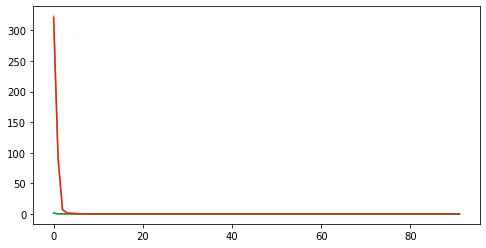

In [103]:
run(fold=1)

--------Training Begining for fold 3-------------
Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
Current learning rate:  0.02
| 1     | -1.59115 |  -57.64458 |   2.5       
Current learning rate:  0.02
| 2     | -0.33833 |  -9.64072 |   5.1       
Current learning rate:  0.02
| 3     | -0.14040 |  -2.47373 |   7.5       
Current learning rate:  0.02
| 4     | -0.09257 |  -3.06410 |   10.0      
Current learning rate:  0.02
| 5     | -0.07412 |  -0.43414 |   12.4      
Current learning rate:  0.02
| 6     | -0.06184 |  -0.53068 |   15.2      
Current learning rate:  0.02
| 7     | -0.04937 |  -0.27702 |   18.1      
Current learning rate:  0.02
| 8     | -0.04770 |  -0.19388 |   20.8      
Current learning rate:  0.02
| 9     | -0.04539 |  -0.24706 |   23.3      
Current learning rate:  0.02
| 10    | -0.04215 |  -0.08523 |   25.9      
Current learning rate:  0.02
| 11    | 

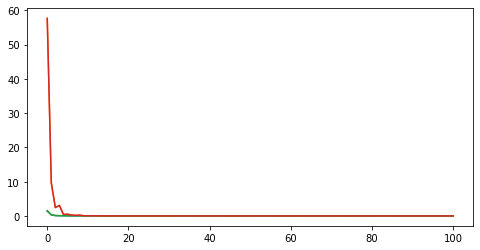

In [104]:
run(fold=2)

--------Training Begining for fold 4-------------
Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
Current learning rate:  0.02
| 1     | -1.25571 |  -21.22816 |   2.6       
Current learning rate:  0.02
| 2     | -0.30853 |  -11.82255 |   5.2       
Current learning rate:  0.02
| 3     | -0.13888 |  -2.54096 |   8.7       
Current learning rate:  0.02
| 4     | -0.08934 |  -2.47569 |   11.8      
Current learning rate:  0.02
| 5     | -0.06970 |  -0.38567 |   15.0      
Current learning rate:  0.02
| 6     | -0.05541 |  -0.28321 |   18.2      
Current learning rate:  0.02
| 7     | -0.04824 |  -0.26287 |   20.9      
Current learning rate:  0.02
| 8     | -0.04378 |  -0.15826 |   23.7      
Current learning rate:  0.02
| 9     | -0.04175 |  -0.08091 |   26.4      
Current learning rate:  0.02
| 10    | -0.03915 |  -0.06206 |   28.8      
Current learning rate:  0.02
| 11    |

| 107   | -0.03341 |  -0.03682 |   293.6     
Current learning rate:  0.02
| 108   | -0.03322 |  -0.03680 |   296.0     
Current learning rate:  0.02
| 109   | -0.03311 |  -0.03719 |   298.9     
Current learning rate:  0.02
| 110   | -0.03331 |  -0.03699 |   301.3     
Current learning rate:  0.02
| 111   | -0.03334 |  -0.03754 |   304.0     
Current learning rate:  0.02
| 112   | -0.03381 |  -0.03729 |   306.6     
Current learning rate:  0.02
| 113   | -0.03365 |  -0.03685 |   309.3     
Current learning rate:  0.02
| 114   | -0.03284 |  -0.03684 |   312.0     
Current learning rate:  0.02
| 115   | -0.03288 |  -0.03719 |   315.1     
Current learning rate:  0.02
| 116   | -0.03295 |  -0.03704 |   317.8     
Current learning rate:  0.02
| 117   | -0.03309 |  -0.03668 |   320.6     
Current learning rate:  0.02
| 118   | -0.03313 |  -0.03682 |   323.3     
Early stopping occured at epoch 118
Training done in 323.349 seconds.
---------------------------------------
--------Validating 

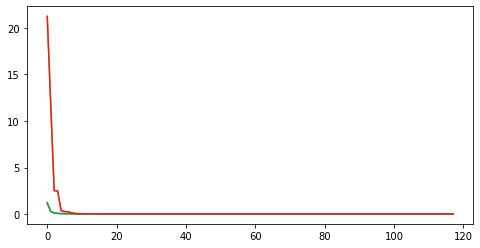

In [105]:
run(fold=3)

In [106]:
y_tes = y_test.mean(axis=-1) # Taking mean of all the fold predictions

In [107]:
y_tes

array([[0.17794737],
       [0.18304728],
       [0.17835943],
       ...,
       [0.15356284],
       [0.1750649 ],
       [0.21984392]])

In [108]:
sub = pd.DataFrame()
sub['Employee_ID'] = EMP_ID
sub['Attrition_rate'] = y_tes
sub.to_csv('tabnet_submission.csv',index=False)

In [82]:
sub = pd.read_csv("tabnet_submission.csv")
sub.shape

(3000, 2)

In [83]:
test.shape

(3000, 24)

In [85]:
ypred = model.predict(test[features].values)

In [91]:
sub = pd.DataFrame()
sub['Employee_ID'] = test['Employee_ID']
sub['Attrition_rate'] = y_test
sub.to_csv('tabnet_submission.csv',index=False)

In [88]:
test = pd.read_csv('Test.csv')

In [22]:
y_test.shape

(3000, 1, 5)

In [25]:
u = model.predict(test[features].values)
u.shape

(3000, 1)